In [1]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
%pylab inline
#%matplotlib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

#import stats packages
import statsmodels.api as sm

Populating the interactive namespace from numpy and matplotlib


In [2]:
filename = "shortened.csv"

#create sample dataframe 
global_temp_city  = pd.read_csv(filename).dropna()
#global_temp_city = global_temp_city.drop('Unnamed: 0', 1)   #this is here for if we used the random files that albert added on github

#format dt column to be a datetime value 
global_temp_city['dt'] =  pd.to_datetime(global_temp_city['dt'])
global_temp_city['AverageTemperature'] = global_temp_city['AverageTemperature']*(1.8)+32
global_temp_city[:6]

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01 00:00:00,42.9224,1.737,Århus,Denmark,57.05N,10.33E
5,1744-04-01 00:00:00,42.4184,3.624,Århus,Denmark,57.05N,10.33E
6,1744-05-01 00:00:00,51.1592,1.283,Århus,Denmark,57.05N,10.33E
7,1744-06-01 00:00:00,57.2918,1.347,Århus,Denmark,57.05N,10.33E
8,1744-07-01 00:00:00,60.9476,1.396,Århus,Denmark,57.05N,10.33E
10,1744-09-01 00:00:00,55.0058,1.454,Århus,Denmark,57.05N,10.33E


In [3]:
#create new column for year and average temp for each year 
global_temp_city['year']= global_temp_city['dt'].map(lambda x: x.date().year)
global_temp_city[0:6]

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year
0,1743-11-01 00:00:00,42.9224,1.737,Århus,Denmark,57.05N,10.33E,1743
5,1744-04-01 00:00:00,42.4184,3.624,Århus,Denmark,57.05N,10.33E,1744
6,1744-05-01 00:00:00,51.1592,1.283,Århus,Denmark,57.05N,10.33E,1744
7,1744-06-01 00:00:00,57.2918,1.347,Århus,Denmark,57.05N,10.33E,1744
8,1744-07-01 00:00:00,60.9476,1.396,Århus,Denmark,57.05N,10.33E,1744
10,1744-09-01 00:00:00,55.0058,1.454,Århus,Denmark,57.05N,10.33E,1744


In [4]:
yearlyAvgCountryTemps = global_temp_city.groupby(['Country','year'])['AverageTemperature'].mean()


# create dataframe with info
yearlyAvgCountryTempsDF = DataFrame({'avgTemp':yearlyAvgCountryTemps.values,'temporary':yearlyAvgCountryTemps.index.values})
yearlyAvgCountryTempsDF['Country'] = yearlyAvgCountryTempsDF['temporary'].map(lambda x : x[0])
yearlyAvgCountryTempsDF['year'] = yearlyAvgCountryTempsDF['temporary'].map(lambda x : x[1])
yearlyAvgCountryTempsDF = yearlyAvgCountryTempsDF.drop('temporary', 1)   

yearlyAvgCountryTempsDF[:10]

,avgTemp,Country,year
0,59.976050,Australia,1841
1,60.106700,Australia,1842
2,60.593450,Australia,1843
3,59.462450,Australia,1844
4,60.124400,Australia,1845
5,61.007750,Australia,1846
6,60.120950,Australia,1847
7,59.553500,Australia,1848
8,59.350550,Australia,1849
9,60.222691,Australia,1850


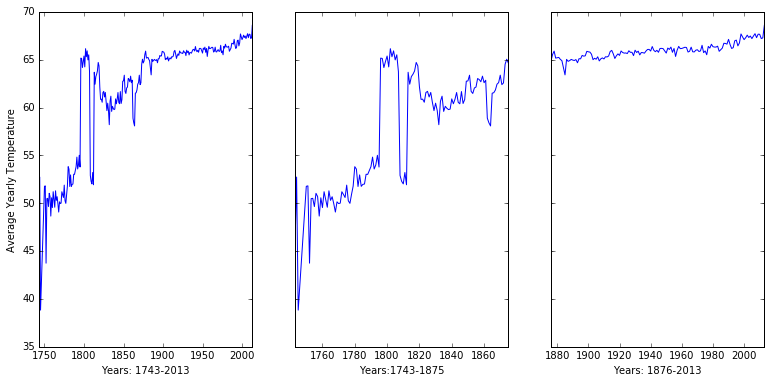

In [5]:
# average temperatures for different years
yearlyAvgTemps = global_temp_city.groupby('year')['AverageTemperature'].mean()
yearlyTempCount = global_temp_city.groupby('year')['AverageTemperature'].count()

# create dataframe with info
yearlyAvgTempsDF = DataFrame({'avgTemp':yearlyAvgTemps.values,'year':yearlyAvgTemps.index.values})


#built this subplot to look at the avg temp per year and compare two different time frames where the temperature 
#measurements seem to be wildly different. I think this has to do with thermometer technology improving over time
#first plot shows all years, second plot shows 1743-1875, third shows 1876 -2013
fig, (ax1,ax2,ax3)= subplots(nrows=1, ncols=3,sharey=True,figsize=(13,6))
yearlyAvgTemps.plot(ax=ax1)
ax1.set_ylabel('Average Yearly Temperature')
ax1.set_xlabel('Years: 1743-2013')
yearlyAvgTemps[:129].plot(ax=ax2)
ax2.set_xlabel('Years:1743-1875')
yearlyAvgTemps[129:].plot(ax=ax3)
ax3.set_xlabel('Years: 1876-2013')

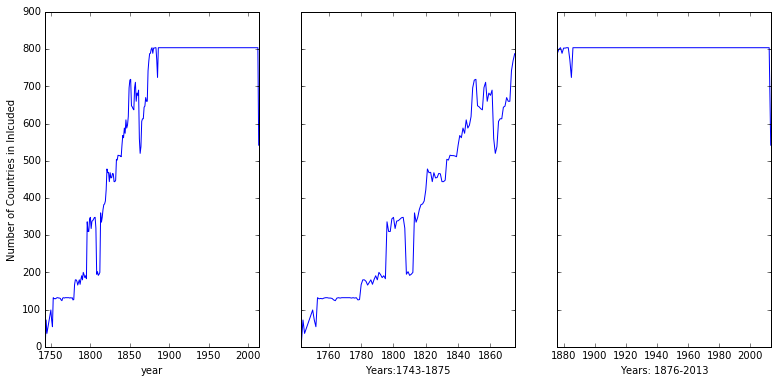

In [6]:
fig2, (ax1,ax2,ax3)= subplots(nrows=1, ncols=3,sharey=True,figsize=(13,6))
yearlyTempCount.plot(ax=ax1)
ax1.set_ylabel('Number of Countries in Inlcuded')
ax2.set_xlabel('Years: 1743-2013')
yearlyTempCount[:129].plot(ax=ax2)
ax2.set_xlabel('Years:1743-1875')
yearlyTempCount[129:].plot(ax=ax3)
ax3.set_xlabel('Years: 1876-2013')

In [7]:
#Some descriptive stats to show the differences in the time periods that we described above.
#Here we can clearly see through the STD Dev that the first time period had really spread out measurements 
#it stabilized in the second period
DF2= DataFrame()
DF2['All Years']=yearlyAvgTemps.describe()
DF2['1742-1875'] = yearlyAvgTemps[:129].describe()
DF2['1876-2013'] = yearlyAvgTemps[129:].describe()
DF2

,All Years,1742-1875,1876-2013
count,267.000000,129.000000,138.000000
mean,61.916306,57.574621,65.974837
std,5.916471,5.942676,0.792724
min,38.835700,38.835700,63.427247
25%,60.420639,51.822200,65.445815
50%,65.044537,60.138412,65.907179
75%,65.926373,62.587498,66.328485
max,68.605796,66.166098,68.605796


In [8]:
# Now i want to run a regression usuing the yearlyAvgTemps buy separating them by the time periods.

In [9]:
all_years = pd.ols(x=yearlyAvgTempsDF['year'],y=yearlyAvgTempsDF['avgTemp'])
first_group = pd.ols(x=yearlyAvgTempsDF['year'][:129],y=yearlyAvgTempsDF['avgTemp'][:129])
second_group = pd.ols(x=yearlyAvgTempsDF['year'][129:],y=yearlyAvgTempsDF['avgTemp'][129:])


In [10]:
#i printed the result and what I see is that the change over time can be better explained by the change in years
#when separated. the change in temperature  can be better explained by the increase in years after 1875.
print all_years
print first_group
print second_group


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         267
Number of Degrees of Freedom:   2

R-squared:         0.6868
Adj R-squared:     0.6856

Rmse:              3.3172

F-stat (1, 265):   581.1750, p-value:     0.0000

Degrees of Freedom: model 1, resid 265

-----------------------Summary of Estimated Coefficients------------------------
      Variable       Coef    Std Err     t-stat    p-value    CI 2.5%   CI 97.5%
--------------------------------------------------------------------------------
             x     0.0634     0.0026      24.11     0.0000     0.0583     0.0686
     intercept   -57.3345     4.9508     -11.58     0.0000   -67.0381   -47.6310
---------------------------------End of Summary---------------------------------


-------------------------Summary of Regression Analysis-------------------------

Formula: Y ~ <x> + <intercept>

Number of Observations:         129
Number

In [11]:
# add city, country column to main DF
global_temp_city["city_country"] = global_temp_city["City"]+", "+global_temp_city['Country']
#a mask that filters out the years so we can filter out the old data that we decided not to use for analysis
year_mask = (global_temp_city['year']>1875)
global_temp_city_masked = global_temp_city[year_mask]


In [12]:
# merge original dataframe with yearly averages dataframe
global_temp_city_w_yrlyAvg = pd.merge(global_temp_city_masked, yearlyAvgTempsDF,\
                          left_on = 'year', right_on = 'year',\
                           suffixes=['_alldata','avgYearTemps'])
global_temp_city_w_yrlyAvg[:10]


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,year,city_country,avgTemp
0,1876-01-01 00:00:00,30.8300,0.621,Århus,Denmark,57.05N,10.33E,1876,"Århus, Denmark",64.878889
1,1876-02-01 00:00:00,30.6014,0.850,Århus,Denmark,57.05N,10.33E,1876,"Århus, Denmark",64.878889
2,1876-03-01 00:00:00,35.0924,1.432,Århus,Denmark,57.05N,10.33E,1876,"Århus, Denmark",64.878889
3,1876-04-01 00:00:00,42.6794,0.963,Århus,Denmark,57.05N,10.33E,1876,"Århus, Denmark",64.878889
4,1876-05-01 00:00:00,48.3494,0.766,Århus,Denmark,57.05N,10.33E,1876,"Århus, Denmark",64.878889
5,1876-06-01 00:00:00,60.1466,0.418,Århus,Denmark,57.05N,10.33E,1876,"Århus, Denmark",64.878889
6,1876-07-01 00:00:00,62.3480,0.593,Århus,Denmark,57.05N,10.33E,1876,"Århus, Denmark",64.878889
7,1876-08-01 00:00:00,61.6262,0.370,Århus,Denmark,57.05N,10.33E,1876,"Århus, Denmark",64.878889
8,1876-09-01 00:00:00,54.1328,0.611,Århus,Denmark,57.05N,10.33E,1876,"Århus, Denmark",64.878889
9,1876-10-01 00:00:00,47.6546,0.608,Århus,Denmark,57.05N,10.33E,1876,"Århus, Denmark",64.878889


In [13]:
# average temperatures for all years for different cities
cityAvgTempsAllYrs = global_temp_city_masked.groupby(['city_country','Latitude','Longitude'])['AverageTemperature'].mean()

#create dataframe with information (because series suck)
cityAvgTempsAllYrsDF = DataFrame({'temporary':cityAvgTempsAllYrs.index.values,\
                           'avgTemp':cityAvgTempsAllYrs.values})
cityAvgTempsAllYrsDF['city_country'] = cityAvgTempsAllYrsDF['temporary'].map(lambda x : x[0])
cityAvgTempsAllYrsDF['lat'] = cityAvgTempsAllYrsDF['temporary'].map(lambda x : x[1])
cityAvgTempsAllYrsDF['long'] = cityAvgTempsAllYrsDF['temporary'].map(lambda x : x[2])
cityAvgTempsAllYrsDF = cityAvgTempsAllYrsDF.drop('temporary', 1)          


cityAvgTempsAllYrsDF[:10]

,avgTemp,city_country,lat,long
0,55.939091,"A Coruña, Spain",42.59N,8.73W
1,48.227964,"Aachen, Germany",50.63N,6.34E
2,46.241722,"Aalborg, Denmark",57.05N,10.33E
3,79.951273,"Aba, Nigeria",5.63N,8.07E
4,77.308226,"Abadan, Iran",29.74N,48.00E
5,79.951273,"Abakaliki, Nigeria",5.63N,8.07E
6,31.361256,"Abakan, Russia",53.84N,91.36E
7,45.327753,"Abbotsford, Canada",49.03N,122.45W
8,79.690309,"Abengourou, Côte D'Ivoire",7.23N,4.05W
9,79.521939,"Abeokuta, Nigeria",7.23N,4.05E


In [14]:
# average temperatures each year for different cities
cityAvgTempsEachYr = global_temp_city_masked.groupby(['city_country','Latitude','Longitude','year'])['AverageTemperature'].mean()

#create dataframe with information (because series suck)
cityAvgTempsEachYrDF = DataFrame({'temporary':cityAvgTempsEachYr.index.values,\
                           'avgTemp':cityAvgTempsEachYr.values})
cityAvgTempsEachYrDF['city_country'] = cityAvgTempsEachYrDF['temporary'].map(lambda x : x[0])
cityAvgTempsEachYrDF['lat'] = cityAvgTempsEachYrDF['temporary'].map(lambda x : x[1])
cityAvgTempsEachYrDF['long'] = cityAvgTempsEachYrDF['temporary'].map(lambda x : x[2])
cityAvgTempsEachYrDF['year'] = cityAvgTempsEachYrDF['temporary'].map(lambda x : x[3])
cityAvgTempsEachYrDF = cityAvgTempsEachYrDF.drop('temporary', 1)          


print cityAvgTempsEachYrDF[:10]

    avgTemp     city_country     lat   long  year
0  55.61075  A Coruña, Spain  42.59N  8.73W  1876
1  55.88285  A Coruña, Spain  42.59N  8.73W  1877
2  55.35350  A Coruña, Spain  42.59N  8.73W  1878
3  54.07535  A Coruña, Spain  42.59N  8.73W  1879
4  55.10795  A Coruña, Spain  42.59N  8.73W  1880
5  56.12900  A Coruña, Spain  42.59N  8.73W  1881
6  54.99725  A Coruña, Spain  42.59N  8.73W  1882
7  54.06950  A Coruña, Spain  42.59N  8.73W  1883
8  54.84785  A Coruña, Spain  42.59N  8.73W  1884
9  54.07070  A Coruña, Spain  42.59N  8.73W  1885


In [15]:
cityAvgTempsEachYrRange = cityAvgTempsEachYrDF.groupby(['city_country','lat','long'])['avgTemp'].agg(lambda x: x.max() - x.min())

pre_clusteringDF = DataFrame({'temporary':cityAvgTempsEachYrRange.index.values,\
                           'regResults':cityAvgTempsEachYrRange.values})
pre_clusteringDF['city_country'] = pre_clusteringDF['temporary'].map(lambda x : x[0])
pre_clusteringDF['lat'] = pre_clusteringDF['temporary'].map(lambda x : x[1])
pre_clusteringDF['long'] = pre_clusteringDF['temporary'].map(lambda x : x[2])
pre_clusteringDF = pre_clusteringDF.drop('temporary', 1) 

pre_clusteringDF[:10]

,regResults,city_country,lat,long
0,5.43270,"A Coruña, Spain",42.59N,8.73W
1,6.16725,"Aachen, Germany",50.63N,6.34E
2,6.52140,"Aalborg, Denmark",57.05N,10.33E
3,4.98600,"Aba, Nigeria",5.63N,8.07E
4,7.20540,"Abadan, Iran",29.74N,48.00E
5,4.98600,"Abakaliki, Nigeria",5.63N,8.07E
6,8.82870,"Abakan, Russia",53.84N,91.36E
7,7.42625,"Abbotsford, Canada",49.03N,122.45W
8,4.40850,"Abengourou, Côte D'Ivoire",7.23N,4.05W
9,5.26965,"Abeokuta, Nigeria",7.23N,4.05E


In [16]:
cityAvgTempsAllYrsDF['regResults']= pre_clusteringDF['regResults']
cityAvgTempsAllYrsDF[:10]


,avgTemp,city_country,lat,long,regResults
0,55.939091,"A Coruña, Spain",42.59N,8.73W,5.43270
1,48.227964,"Aachen, Germany",50.63N,6.34E,6.16725
2,46.241722,"Aalborg, Denmark",57.05N,10.33E,6.52140
3,79.951273,"Aba, Nigeria",5.63N,8.07E,4.98600
4,77.308226,"Abadan, Iran",29.74N,48.00E,7.20540
5,79.951273,"Abakaliki, Nigeria",5.63N,8.07E,4.98600
6,31.361256,"Abakan, Russia",53.84N,91.36E,8.82870
7,45.327753,"Abbotsford, Canada",49.03N,122.45W,7.42625
8,79.690309,"Abengourou, Côte D'Ivoire",7.23N,4.05W,4.40850
9,79.521939,"Abeokuta, Nigeria",7.23N,4.05E,5.26965


In [17]:
# create pivottable/timeseries
date_city_pivot = pd.pivot_table(cityAvgTempsEachYrDF,\
                                index='year',\
                                columns='city_country')
date_city_pivot[:5]


avgTemp                                                \
city_country A Coruña, Spain Aachen, Germany Aalborg, Denmark Aba, Nigeria   
year                                                                         
1876                55.61075        47.95955         44.55440     78.79820   
1877                55.88285        47.98355         44.18000     79.61585   
1878                55.35350        47.90000         46.48760     79.41470   
1879                54.07535        45.01115         43.05200     78.23990   
1880                55.10795        48.16820         46.13555     78.79310   

                                                             \
city_country Abadan, Iran Abakaliki, Nigeria Abakan, Russia   
year                                                          
1876             76.57730           78.79820       29.89040   
1877             77.52665           79.61585       30.70925   
1878             77.35880           79.41470       30.88565   
1879             77.53625           78.23990       30.81020   
1880             75.72545           78.79310       31.38380   

                                                                             \
city_country Abbotsford, Canada Abengourou, Côte D'Ivoire Abeokuta, Nigeria   
year                                                                          
1876                   44.03930                  77.78870          78.77080   
1877                   46.33055                  78.97325          79.06970   
1878                   46.26710                  79.11965          78.97535   
1879                   43.73900                  78.25595          77.92655   
1880                   42.30815                  79.23875          78.63500   

                  ...                                                      \
city_country      ...      Akyab, Burma Alagoinhas, Brazil Alandur, India   
year              ...                                                       
1876              ...          77.51750           76.43465       83.10020   
1877              ...          77.65130           77.32760       83.70575   
1878              ...          79.25780           78.32600       83.86265   
1879              ...          78.35345           76.49930       82.39505   
1880              ...          77.55590           77.32625       82.70045   

                                                                           \
city_country Alanya, Turkey Alappuzha, India Århus, Denmark Çorlu, Turkey   
year                                                                        
1876               65.05850         78.85025       44.55440      56.09780   
1877               65.25500         79.35590       44.18000      55.97870   
1878               65.28845         79.66790       46.48760      56.70455   
1879               65.98385         78.64355       43.05200      56.67980   
1880               63.35045         78.61160       46.13555      54.41180   

                                                              
city_country Çorum, Turkey Öskemen, Kazakhstan Ürümqi, China  
year                                                          
1876              49.89545            33.04505      41.65265  
1877              50.09675            33.65870      41.68565  
1878              50.74250            34.78640      42.33080  
1879              50.90750            34.87775      43.23455  
1880              47.49560            35.01020      43.23845  

[5 rows x 67 columns]

In [18]:
# a df that shows the change in temp per year
#test1 = date_city_pivot - date_city_pivot.shift(1)

In [19]:
def regressOnYr(s):
    sDF = DataFrame({'year':s.index.values,\
                           'temps':s.values})
    result = pd.ols(x=sDF['year'],y=sDF['temps'])
    return result
    
    

In [20]:
timeOnAvgTempEachCity = date_city_pivot.apply(regressOnYr)

#change to datafram
timeOnAvgTempEachCityDF = DataFrame({'temporary':timeOnAvgTempEachCity.index.values,\
                           'regResults':timeOnAvgTempEachCity.values})
timeOnAvgTempEachCityDF['city_country'] = timeOnAvgTempEachCityDF['temporary'].map(lambda x : x[1])
timeOnAvgTempEachCityDF = timeOnAvgTempEachCityDF.drop('temporary', 1) 

#add relevant regression information to DF
timeOnAvgTempEachCityDF['slope']=timeOnAvgTempEachCityDF['regResults'].map(lambda x: x.beta['x'])
timeOnAvgTempEachCityDF['Y-intercept']=timeOnAvgTempEachCityDF['regResults'].map(lambda x: x.beta['intercept'])
timeOnAvgTempEachCityDF['R2']=timeOnAvgTempEachCityDF['regResults'].map(lambda x: x.r2)
timeOnAvgTempEachCityDF['pval']=timeOnAvgTempEachCityDF['regResults'].map(lambda x: x.p_value)

timeOnAvgTempEachCityDF[:10]


,regResults,city_country,slope,Y-intercept,R2,pval
0,\n-------------------------Summary of Regressi...,"A Coruña, Spain",0.016881,23.117796,0.406746,x 4.032884e-17 intercept 3.03102...
1,\n-------------------------Summary of Regressi...,"Aachen, Germany",0.018675,11.916006,0.325065,x 2.896665e-13 intercept 8.87412...
2,\n-------------------------Summary of Regressi...,"Aalborg, Denmark",0.017372,12.464129,0.205256,x 2.411188e-08 intercept 3.05030...
3,\n-------------------------Summary of Regressi...,"Aba, Nigeria",0.017728,45.480336,0.588105,x 5.661970e-28 intercept 1.10586...
4,\n-------------------------Summary of Regressi...,"Abadan, Iran",0.019134,40.109772,0.395302,x 1.499142e-16 intercept 2.12907...
5,\n-------------------------Summary of Regressi...,"Abakaliki, Nigeria",0.017728,45.480336,0.588105,x 5.661970e-28 intercept 1.10586...
6,\n-------------------------Summary of Regressi...,"Abakan, Russia",0.025204,-17.636008,0.330797,x 1.608348e-13 intercept 3.74389...
7,\n-------------------------Summary of Regressi...,"Abbotsford, Canada",0.014730,16.693676,0.216192,x 9.171591e-09 intercept 4.95786...
8,\n-------------------------Summary of Regressi...,"Abengourou, Côte D'Ivoire",0.017972,44.742747,0.606127,x 2.662566e-29 intercept 5.35200...
9,\n-------------------------Summary of Regressi...,"Abeokuta, Nigeria",0.017852,44.807147,0.548558,x 2.986384e-25 intercept 1.75219...


In [21]:
neg_mask = (timeOnAvgTempEachCityDF['slope']<0)

In [22]:
abc = timeOnAvgTempEachCityDF[neg_mask]

In [23]:
abc

,regResults,city_country,slope,Y-intercept,R2,pval


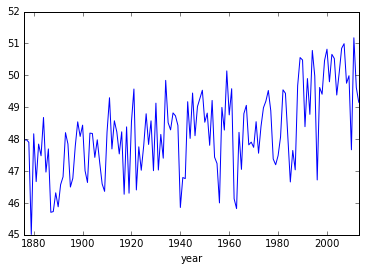

In [24]:
#print test1['avgTemp']['Aachen, Germany']
date_city_pivot['avgTemp']['Aachen, Germany'].plot()


In [25]:
#load all indicator files  

filename = "agricultureland.csv"

#create sample dataframe 
agland  = pd.read_csv(filename).dropna()

filename = "arableland.csv"

#create sample dataframe 
arableland  = pd.read_csv(filename).dropna()

filename = "avgPrec.csv"

#create sample dataframe 
avgPrec  = pd.read_csv(filename).dropna()

filename = "CO2emissions.csv"

#create sample dataframe 
CO2  = pd.read_csv(filename).dropna()

filename = "cropProduction.csv"

#create sample dataframe 
cropProd  = pd.read_csv(filename).dropna()

filename = "foodProduction.csv"

#create sample dataframe 
foodProd  = pd.read_csv(filename).dropna()

filename = "Livestock.csv"

#create sample dataframe 
livestock  = pd.read_csv(filename).dropna()

indicatorFile = [agland,arableland,avgPrec,CO2,cropProd,foodProd,livestock]


In [26]:
[agland,arableland,avgPrec,CO2,cropProd,foodProd,livestock]
# merge first two indicator tables
CO2Ag = pd.merge(agland, CO2, how='outer',left_on=['CountryName','CountryCode', 'Year'],\
                 right_on=['CountryName','CountryCode', 'Year'])

arablePrec = pd.merge(arableland, avgPrec, how='outer',left_on=['CountryName','CountryCode', 'Year'],\
                      right_on=['CountryName','CountryCode', 'Year'])

cropfood = pd.merge(cropProd, foodProd, how='outer',left_on=['CountryName','CountryCode', 'Year'],\
                    right_on=['CountryName','CountryCode', 'Year'])

CO2Aglivestock = pd.merge(livestock, CO2Ag, how='outer',left_on=['CountryName','CountryCode', 'Year'],\
                          right_on=['CountryName','CountryCode', 'Year'])

arablePrecCO2Aglivestock = pd.merge(CO2Aglivestock, arablePrec, how='outer',left_on=['CountryName','CountryCode', 'Year'],\
                          right_on=['CountryName','CountryCode', 'Year'])
indicators = pd.merge(arablePrecCO2Aglivestock, cropfood, how='outer',left_on=['CountryName','CountryCode', 'Year'],\
                          right_on=['CountryName','CountryCode', 'Year'])

#indicators[indicators['Year']==1965]

In [27]:
#merge cityAvgTempsEachYrDF with indicator table
cityDataPerYr = pd.merge(yearlyAvgCountryTempsDF, indicators, left_on=['Country','year'],right_on=['CountryName',\
                                                'Year'])

cityDataPerYr = cityDataPerYr.drop('CountryName', 1)
cityDataPerYr = cityDataPerYr.drop('Year', 1) 

cityDataPerYr[:10]

,avgTemp,Country,year,CountryCode,Livestock,HarvestingLand,CO2Emissions,ArableLand,AveragePrecipitation,CropProduction,Foodproduction
0,60.03590,Australia,1960,AUS,NaN,NaN,88202.351,NaN,NaN,NaN,NaN
1,62.25920,Australia,1961,AUS,51.45,60.084220,90589.568,3.929162,NaN,24.96,38.95
2,61.33895,Australia,1962,AUS,56.45,60.357966,94912.961,4.178827,534.0,29.85,44.13
3,61.27490,Australia,1963,AUS,59.12,60.720227,101029.517,4.300014,NaN,30.23,45.94
4,59.89805,Australia,1964,AUS,61.43,61.050597,108979.573,4.605392,NaN,34.23,49.03
5,61.52615,Australia,1965,AUS,62.47,61.566979,120966.996,4.811840,NaN,28.92,47.22
6,60.55700,Australia,1966,AUS,60.84,61.720318,120332.605,5.156529,NaN,40.14,51.92
7,61.43630,Australia,1967,AUS,60.76,62.055374,129265.417,5.373130,534.0,31.14,47.14
8,61.01885,Australia,1968,AUS,61.83,61.807141,134622.904,5.387709,NaN,44.97,54.26
9,60.47105,Australia,1969,AUS,64.38,62.343699,142257.598,5.402028,NaN,37.61,51.30


In [28]:
#create regression model to see if indicators help in predicting temperatarue


y, X = dmatrices('avgTemp ~ year + Livestock + HarvestingLand + CO2Emissions + ArableLand + AveragePrecipitation + CropProduction + Foodproduction', data = cityDataPerYr , return_type = 'dataframe')

X[:3]

#run the regression

model = sm.OLS(y,X)
result = model.fit()
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                avgTemp   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.533
Method:                 Least Squares   F-statistic:                     13.42
Date:                Mon, 02 May 2016   Prob (F-statistic):           4.53e-12
Time:                        02:10:17   Log-Likelihood:                -314.33
No. Observations:                  88   AIC:                             646.7
Df Residuals:                      79   BIC:                             669.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept             -696.0116 

In [29]:
#remove variables with highest alpha which is HarvestingLand
#removing harvestingLand and Arable land brind r-square to .567

y, X = dmatrices('avgTemp ~ year + Livestock + CO2Emissions + AveragePrecipitation + CropProduction + Foodproduction', data = cityDataPerYr , return_type = 'dataframe')

X[:3]

#run the regression

model = sm.OLS(y,X)
result = model.fit()
print result.summary()


                            OLS Regression Results                            
Dep. Variable:                avgTemp   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     17.65
Date:                Mon, 02 May 2016   Prob (F-statistic):           5.80e-13
Time:                        02:10:21   Log-Likelihood:                -315.32
No. Observations:                  88   AIC:                             644.6
Df Residuals:                      81   BIC:                             662.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept             -650.1413 

In [30]:
cityAvgTempsAllYrsDF[:10]


,avgTemp,city_country,lat,long,regResults
0,55.939091,"A Coruña, Spain",42.59N,8.73W,5.43270
1,48.227964,"Aachen, Germany",50.63N,6.34E,6.16725
2,46.241722,"Aalborg, Denmark",57.05N,10.33E,6.52140
3,79.951273,"Aba, Nigeria",5.63N,8.07E,4.98600
4,77.308226,"Abadan, Iran",29.74N,48.00E,7.20540
5,79.951273,"Abakaliki, Nigeria",5.63N,8.07E,4.98600
6,31.361256,"Abakan, Russia",53.84N,91.36E,8.82870
7,45.327753,"Abbotsford, Canada",49.03N,122.45W,7.42625
8,79.690309,"Abengourou, Côte D'Ivoire",7.23N,4.05W,4.40850
9,79.521939,"Abeokuta, Nigeria",7.23N,4.05E,5.26965


In [75]:
#Define a function to convert the North and South latitude to scalable items
def stripNS(string):
    if type(string) != 'str':
        return string
    
    if string[-1] == 'N':
        string = string.rstrip('N')
        string = float(string) * 1
    else:
        string = string.rstrip('S')
        string = float(string) * -1
    return string


In [76]:
def stripWE(string):
    #print type(string)
    if type(string) != 'str':
        #print 'not eqal'
        return string
    
    if string[-1] == 'W':
        string = string.rstrip('W')
        string = float(string) * -1
    else:
        string = string.rstrip('E')
        string = float(string) * 1
    return string
#Apply the function to all rows of ['lat']


In [77]:
#Apply the function to all rows of ['lat']
cityAvgTempsAllYrsDF['lat'] = cityAvgTempsAllYrsDF['lat'].map(stripNS)
cityAvgTempsAllYrsDF['long'] = cityAvgTempsAllYrsDF['long'].map(stripWE)

In [78]:
print cityAvgTempsAllYrsDF

      avgTemp                     city_country    lat    long  regResults  \
0   55.939091                  A Coruña, Spain  42.59   -8.73    5.432700   
1   48.227964                  Aachen, Germany  50.63    6.34    6.167250   
2   46.241722                 Aalborg, Denmark  57.05   10.33    6.521400   
3   79.951273                     Aba, Nigeria   5.63    8.07    4.986000   
4   77.308226                     Abadan, Iran  29.74   48.00    7.205400   
5   79.951273               Abakaliki, Nigeria   5.63    8.07    4.986000   
6   31.361256                   Abakan, Russia  53.84   91.36    8.828700   
7   45.327753               Abbotsford, Canada  49.03 -122.45    7.426250   
8   79.690309        Abengourou, Côte D'Ivoire   7.23   -4.05    4.408500   
9   79.521939                Abeokuta, Nigeria   7.23    4.05    5.269650   
10  47.244305         Aberdeen, United Kingdom  57.05   -1.48    5.300100   
11  76.183796               Abha, Saudi Arabia  18.48   42.25    5.091450   

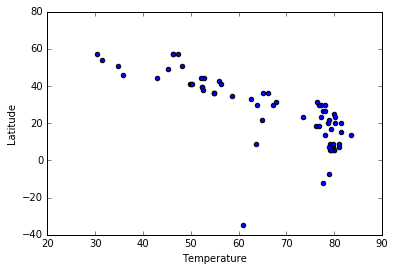

In [79]:
#Visualize the relationship between average temperature and latitude
sc = scatter(cityAvgTempsAllYrsDF['avgTemp'],cityAvgTempsAllYrsDF['lat'], cmap= 'bwr')
xlabel('Temperature')
ylabel('Latitude')

In [80]:
#Initial K-means
from sklearn.cluster import KMeans

In [81]:
numClustersUsed = 5
model = KMeans(n_clusters=numClustersUsed, random_state=1)


In [82]:
cityAvgTempsAllYrsDF[:10]

,avgTemp,city_country,lat,long,regResults,lat2
0,55.939091,"A Coruña, Spain",42.59,-8.73,5.43270,42.59
1,48.227964,"Aachen, Germany",50.63,6.34,6.16725,50.63
2,46.241722,"Aalborg, Denmark",57.05,10.33,6.52140,57.05
3,79.951273,"Aba, Nigeria",5.63,8.07,4.98600,5.63
4,77.308226,"Abadan, Iran",29.74,48.00,7.20540,29.74
5,79.951273,"Abakaliki, Nigeria",5.63,8.07,4.98600,5.63
6,31.361256,"Abakan, Russia",53.84,91.36,8.82870,53.84
7,45.327753,"Abbotsford, Canada",49.03,-122.45,7.42625,49.03
8,79.690309,"Abengourou, Côte D'Ivoire",7.23,-4.05,4.40850,7.23
9,79.521939,"Abeokuta, Nigeria",7.23,4.05,5.26965,7.23


In [83]:
X= cityAvgTempsAllYrsDF[['avgTemp','lat','long','regResults']].values

In [84]:
model.fit(X)


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

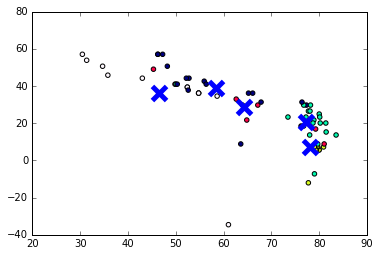

In [85]:
scatter(X[:,0], X[:,1], c=model.labels_, cmap='gist_ncar')
scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], marker="x", s=200, linewidths=5)

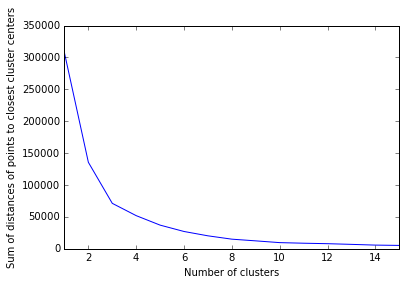

In [86]:
sum_of_distances = {}
for num_clusters in range(1,16):
    kmeans = KMeans(n_clusters=num_clusters, random_state=1)
    kmeans.fit(X)
    sum_of_distances[num_clusters] = kmeans.inertia_
Series(sum_of_distances).sort_index().plot()
xlabel('Number of clusters')
ylabel('Sum of distances of points to closest cluster centers')


In [87]:
for cluster in range(numClustersUsed):
    clusterVals = X[model.labels_ == cluster]
    print "Cluster" + str(cluster) + ": "
    print DataFrame(clusterVals)

Cluster0: 
            0      1      2          3
0   55.939091  42.59  -8.73   5.432700
1   48.227964  50.63   6.34   6.167250
2   46.241722  57.05  10.33   6.521400
3   77.308226  29.74  48.00   7.205400
4   47.244305  57.05  -1.48   5.300100
5   76.183796  18.48  42.25   5.091450
6   66.068307  36.17  35.80   6.359700
7   63.578135   8.84  38.11   5.166450
8   52.405705  39.38  31.21   6.870750
9   76.375981  31.35  49.01   7.540350
10  52.754874  44.20   4.47   5.405250
11  67.828138  31.35  20.73   4.750500
12  52.594566  37.78  34.58   7.906500
13  52.196633  44.20  51.43  10.575750
14  65.197280  36.17  31.82   5.831250
15  46.241722  57.05  10.33   6.521400
16  56.347130  40.99  27.69   6.436875
17  50.302853  40.99  34.08   7.545075
Cluster1: 
            0      1       2         3
0   76.751465  29.74   73.85  5.845500
1   79.986041  24.92   54.98  5.514150
2   78.868193  21.70   77.02  4.767150
3   77.986017  13.66   45.41  5.838025
4   81.364088  20.09   78.48  5.060700
5  

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

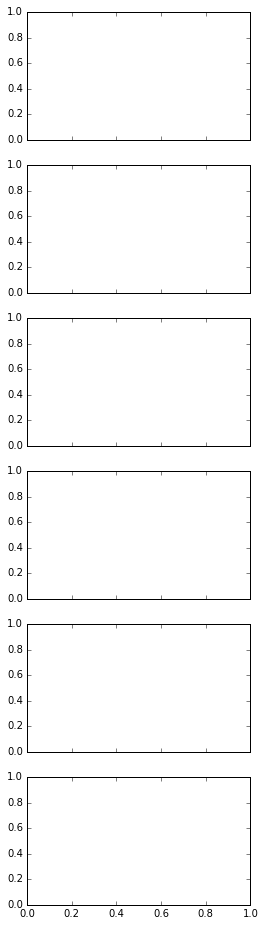

In [89]:
fig3, (ax1,ax2,ax3,ax4,ax5,ax6)= subplots(nrows=6, ncols=1,sharex=True,figsize=(4,16))
clusterVals.plot(ax=ax1)
ax1.set_ylabel('Number of Countries in Inlcuded')
ax2.set_xlabel('Years: 1743-2013')
yearlyTempCount[:129].plot(ax=ax2)
ax2.set_xlabel('Years:1743-1875')
yearlyTempCount[129:].plot(ax=ax3)
ax3.set_xlabel('Years: 1876-2013')